## Προεπεξεργασία Δεδομένων & Ανάπτυξη Μοντέλων Πρόβλεψης - Wisconsin Breast Cancer Diagnostic Dataset
Στόχος αυτού του notebook είναι η προεπεξεργασία του dataset "Wisconsin Breast Cancer Diagnostic Dataset" και στην συνέχεια η ανάπτυξη μοντέλων μηχανικής μάθησης με στόχο την πρόβλεψη του τύπου του καρκίνου σε καλοήθη ή κακοήθη.

In [18]:
# Βιβλιοθήκες
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from scipy import stats 
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier


## 1. Φόρτωση και Προεπεξεργασία του Dataset
Φορτώνουμε το dataset ώστε να αναλύσουμε τα βασικά του στοιχεία και να εκτελέσουμε την προεργασία

In [2]:
# Φορτώνουμε το Dataset και αναλύουμε τα περιεχόμενα του
df = pd.read_csv("C:/Users/nbala/Desktop/BreCanPred/Dataset/wdbc.csv")
print(df.shape) 
df.head() 


(569, 32)


,ID,Diagnosis,Radius1,Texture1,Perimeter1,Area1,Smoothness1,Compactness1,Concavity1,Concave_points1,...,Radius3,Texture3,Perimeter3,Area3,Smoothness3,Compactness3,Concavity3,Concave_points3,Symmetry3,Fractal_dimension3
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Προεργασία των δεδομένων
Α - Διάφορες διεργασίες προεπεξεργασίας (Διαγραφή στήλης ID - Προεπεξεργασία της στήλης Diagnosis)

Β - Η κλάση diagnosis παρουσιάζει μικρή ανισσοροπία αλλά θα την αντιμετωπίσουμε αν χρειαστεί αργότερα

Diagnosis
0    357
1    212
Name: count, dtype: int64


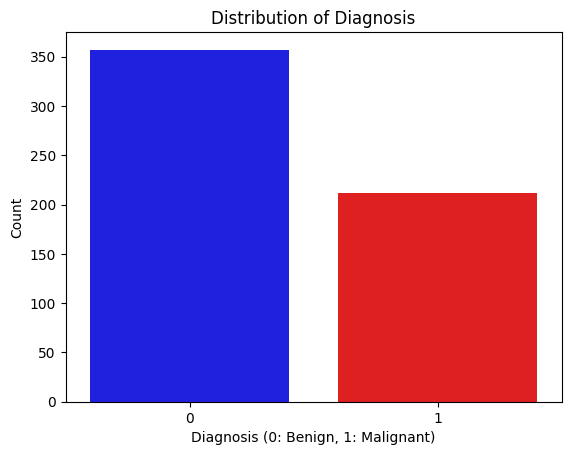

(569, 31)


In [3]:
# Διαγραφή της στήλης ID
if 'ID' in df.columns:
    df.drop(columns=['ID'], inplace=True)

# Μετατροπή των τιμών της στήλης Diagnosis από γράμματα σε αριθμούς
df['Diagnosis'] = df['Diagnosis'].map({'B': 0, 'M': 1}) 
print(df['Diagnosis'].value_counts())

# Διάγραμμα με μπάρες για την κατανομή της στήλης Diagnosis
sns.countplot(x='Diagnosis', data=df, hue='Diagnosis', palette=['blue', 'red'], legend=False)
plt.xlabel('Diagnosis (0: Benign, 1: Malignant)')
plt.ylabel('Count')
plt.title('Distribution of Diagnosis')
plt.show()

print(df.shape)



C - Έλεγχος για Ελλειπούσες τιμές και Διπλότυπα

In [4]:
# έλεγχος για τυχόν ελλείπούσες τιμές
missing_values = df.isnull().sum().sum() # τιμές που λείπουν ανα στήλη
print(f"Total missing values: {missing_values}")

# έλεγχος για διπλότυπα
duplicates = df.duplicated().sum()
print(f"Total Duplicates: {duplicates}")

df.head()
print(df.shape)


Total missing values: 0
Total Duplicates: 0
(569, 31)


D - Ελεγχος για outliers με Z-score και διαγραφή τους σε περίπτωση που χρειάζεται

 outliers: 211

Outliers ανά στήλη:
Radius1                5
Texture1               4
Perimeter1             7
Area1                  8
Smoothness1            5
Compactness1           9
Concavity1             9
Concave_points1        6
Symmetry1              5
Fractal_dimension1     7
Radius2                7
Texture2               9
Perimeter2             8
Area2                  6
Smoothness2            7
Compactness2          12
Concavity2             6
Concave_points2        6
Symmetry2             11
Fractal_dimension2    10
Radius3                6
Texture3               4
Perimeter3             6
Area3                 10
Smoothness3            3
Compactness3          10
Concavity3             7
Concave_points3        0
Symmetry3              9
Fractal_dimension3     9
dtype: int64


<Figure size 1500x1000 with 0 Axes>

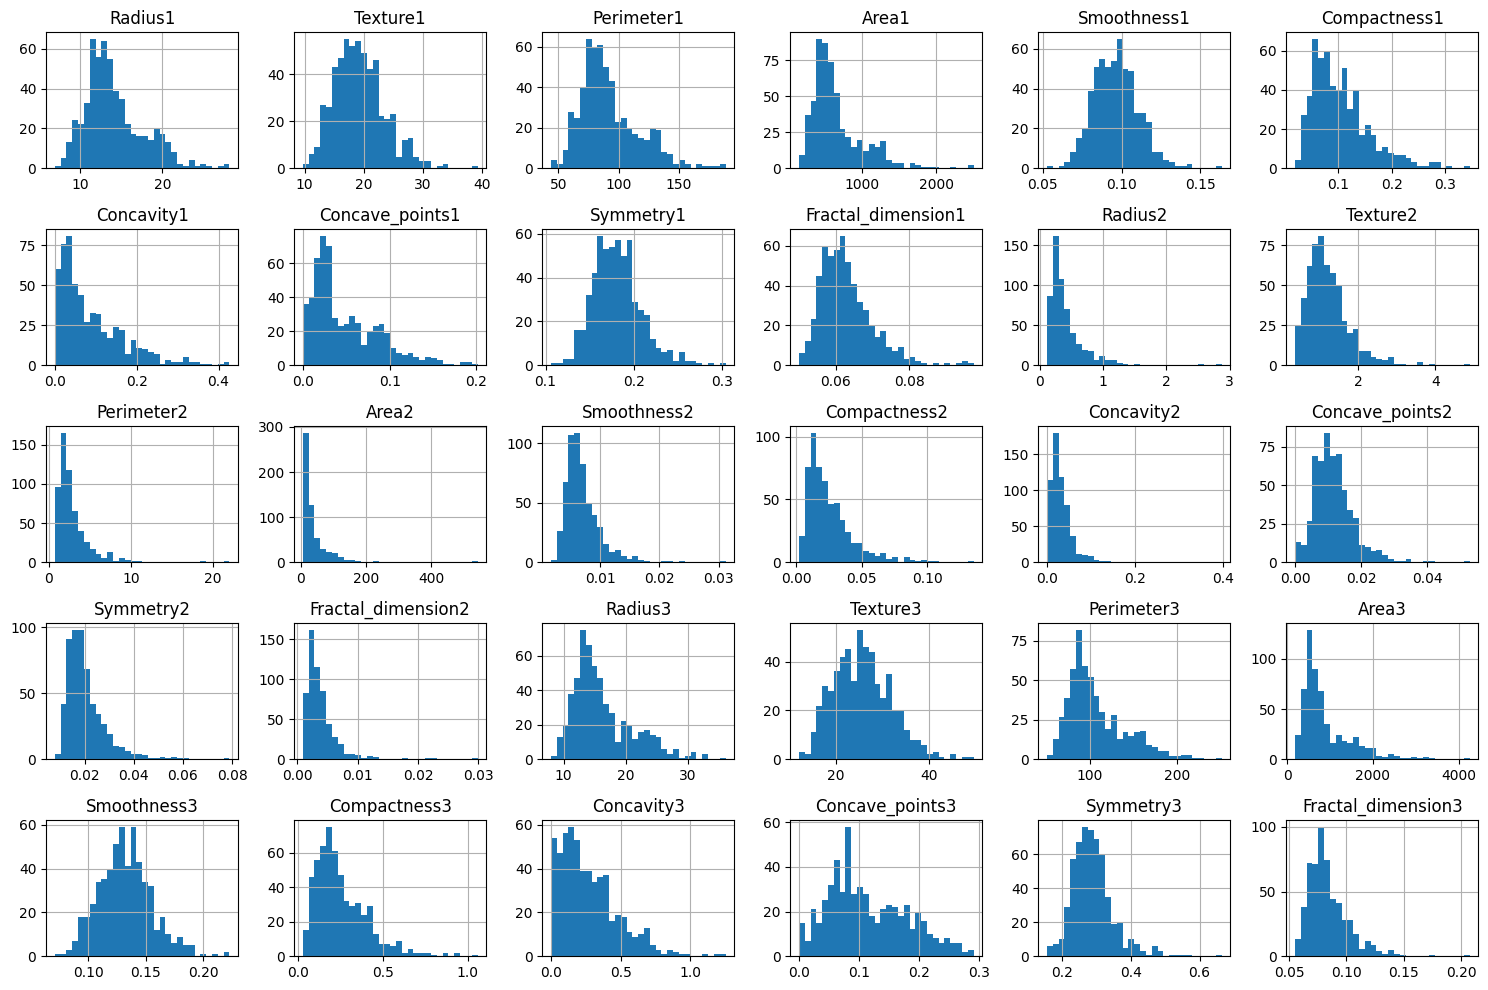

(569, 31)


In [5]:
# Επιλογή μόνο των αριθμητικών στηλών
numeric_cols = df.drop(columns=['Diagnosis']).columns

# Υπολογισμός Z-score
z_scores = np.abs(stats.zscore(df[numeric_cols]))

# Εύρεση outliers
outliers = pd.DataFrame(z_scores > 3, columns=numeric_cols)

# Υπολογισμός outliers για κάθε στήλη
print(" outliers:", outliers.sum().sum())
print("\nOutliers ανά στήλη:")
print(outliers.sum())

# Ιστόγραμμα outliers για κάθε outlier
plt.figure(figsize=(15, 10))
df[numeric_cols].hist(bins=30, layout=(5, 6), figsize=(15, 10))
plt.tight_layout()
plt.show()
print(df.shape)


Ε - Εκτέλεση Feature Selection με Variance Threshold

In [6]:
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# υπολογισμός διακύμανσης για κάθε χαρακτηριστικό
variances = X.var()
variance_df = pd.DataFrame({'Feature': X.columns, 'Variance': variances})
variance_df = variance_df.sort_values(by='Variance', ascending=False)

print("variation of each feature on df_cleaned:")
print(variance_df)

# εκτέλεση της επιλογής με βάση τη διακύμανση
threshold = 0.01  # ορισμός του ορίου διακύμανσης
selector = VarianceThreshold(threshold=threshold)
X_selected = selector.fit_transform(X)

# επιλογή των χαρακτηριστικών με διακύμανση μεγαλύτερη από το όριο
selected_features = X.columns[selector.get_support()].tolist()

print(f"\nfeatures with variance > {threshold}:")
print(selected_features)
print(f"selected features: {len(selected_features)}")

# νέο dataframe με τα επιλεγμένα χαρακτηριστικά
df_selected = df[selected_features + ['Diagnosis']]

print("\nhead of the new dataframe:")
print(df_selected.head())

# έλεγχος του νέου dataframe
print("\ndimentions of df_selected:", df_selected.shape)



variation of each feature on df_cleaned:
                               Feature       Variance
Area3                            Area3  324167.385102
Area1                            Area1  123843.554318
Area2                            Area2    2069.431583
Perimeter3                  Perimeter3    1129.130847
Perimeter1                  Perimeter1     590.440480
Texture3                      Texture3      37.776483
Radius3                        Radius3      23.360224
Texture1                      Texture1      18.498909
Radius1                        Radius1      12.418920
Perimeter2                  Perimeter2       4.087896
Texture2                      Texture2       0.304316
Radius2                        Radius2       0.076902
Concavity3                  Concavity3       0.043524
Compactness3              Compactness3       0.024755
Concavity1                  Concavity1       0.006355
Concave_points3        Concave_points3       0.004321
Symmetry3                    Symmetry3   

Εξαγωγή του cleaned dataset σε ένα νέο αρχείο για την ανάπτυξη μοντέλου

In [7]:
output_path = "C:/Users/nbala/Desktop/BreCanPred/Dataset/wdbc_cleaned.csv"  
df_selected.to_csv(output_path, index=False)

## 3. Εκτέλεση Μοντέλων Μηχανικής μάθησης

3.1 Εκτέλεση Logistic Regression

c:\Users\nbala\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


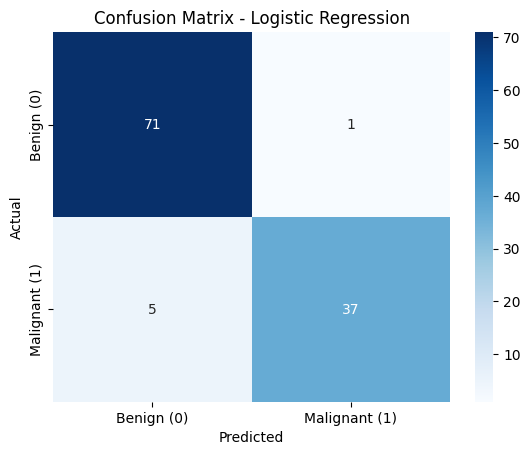

In [14]:
df = pd.read_csv("C:/Users/nbala/Desktop/BreCanPred/Dataset/wdbc_cleaned.csv")
X = df.drop(columns=['Diagnosis'])  
y = df['Diagnosis'] 

# διαχωρισμός σε training και test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# εκτέλεση της Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# προβλέψεις
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign (0)", "Malignant (1)"], 
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


3.2 Ετκέλεση Random Forest

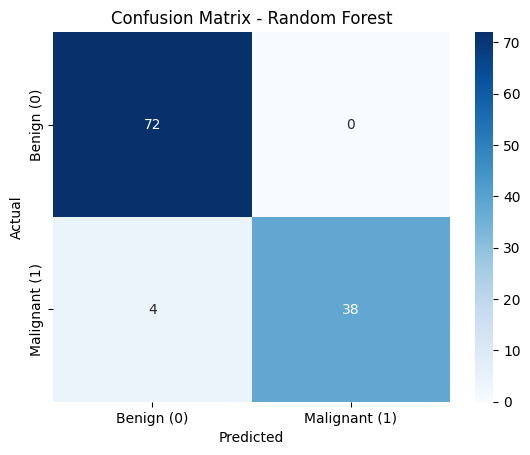

In [15]:
# εκτέλεση του Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42, bootstrap=True, max_depth=10)
model.fit(X_train, y_train)

# προβλέψεις
y_pred = model.predict(X_test)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign (0)", "Malignant (1)"], 
            yticklabels=["Benign (0)", "Malignant (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()


3.3 Εκτέλεση του XGBOOST

c:\Users\nbala\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:05:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


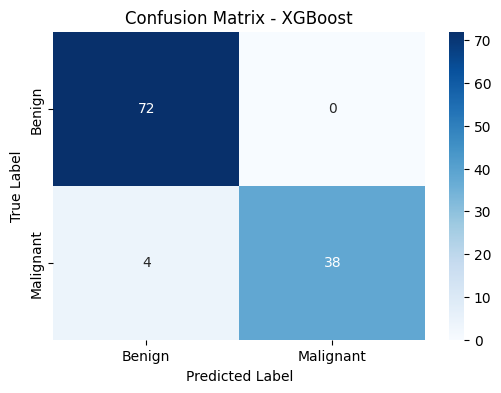

In [19]:
# Διαχωρισμός χαρακτηριστικών και ετικετών
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Διαχωρισμός σε training και test set (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Ορισμός και εκπαίδευση του XGBoost μοντέλου
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Πρόβλεψη στο test set
y_pred = xgb_model.predict(X_test)

# Υπολογισμός και εκτύπωση του Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Οπτικοποίηση του Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - XGBoost")
plt.show()




4. Metrics απόδοσης των μοντέλων

In [25]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, recall_score
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import numpy as np

# Φόρτωση του καθαρισμένου dataset
df = pd.read_csv("C:/Users/nbala/Desktop/BreCanPred/Dataset/wdbc_cleaned.csv")

# Διαχωρισμός χαρακτηριστικών (X) και ετικετών (y)
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Ορισμός των μοντέλων
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Ορισμός του 10-fold Stratified Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Δημιουργία custom scorers για recall ανά κλάση
recall_benign_scorer = make_scorer(recall_score, pos_label=0)  # Benign (0)
recall_malignant_scorer = make_scorer(recall_score, pos_label=1)  # Malignant (1)

# Ορισμός των metrics για cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'recall_benign': recall_benign_scorer,
    'recall_malignant': recall_malignant_scorer
}

# Αποθήκευση αποτελεσμάτων
results = {}

# Εκτέλεση cross-validation και μέτρηση των στατιστικών για κάθε μοντέλο
for name, model in models.items():
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    results[name] = {
        "Accuracy": np.mean(scores['test_accuracy']),
        "Precision": np.mean(scores['test_precision']),
        "Recall": np.mean(scores['test_recall']),
        "F1-score": np.mean(scores['test_f1']),
        "ROC AUC": np.mean(scores['test_roc_auc']),
        "Recall_Benign": np.mean(scores['test_recall_benign']),
        "Recall_Malignant": np.mean(scores['test_recall_malignant'])
    }

# Μετατροπή αποτελεσμάτων σε dataframe 
results_df = pd.DataFrame(results).T

# Εκτύπωση αποτελεσμάτων
print("Αποτελέσματα 10-Fold Stratified Cross-Validation:\n")
print(results_df)


Αποτελέσματα 10-Fold Stratified Cross-Validation:

                     Accuracy  Precision    Recall  F1-score   ROC AUC  \
Logistic Regression  0.952632   0.958747  0.914502  0.933144  0.991962   
Random Forest        0.957863   0.956704  0.933333  0.942096  0.986657   
XGBoost              0.947306   0.937010  0.923810  0.926628  0.989701   

                     Recall_Benign  Recall_Malignant  
Logistic Regression       0.974683          0.914502  
Random Forest             0.971746          0.933333  
XGBoost                   0.960714          0.923810  
